### Seminar 8: Molecular simulations with machine learning potentials

Agenda

- Calculating forces and energies
- ASE calculators and optimizers
- Using universal interatomic potentials
- Thermal expansion
- Li-ion diffusion

### Note: Turn on GPU support

Runtime -> Change runtime type -> T4 GPU

### Part 1: ASE's calculators and optimizers. Fitting the Lennard-Jones pair potential example

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Graph_of_Lennard-Jones_potential.png/1920px-Graph_of_Lennard-Jones_potential.png" width=320 height=200 />


<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/82d16f77cae964a5c4c52fb89165dd5d596ee03f" width=320 height=200 />




There are calculators in ASE. These are used to calculate energies, forces, and stress tensors for a given atomic structure at the given level of theory.  

In [1]:
!pip install ase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.6 MB/s eta 0:00:00


In [8]:
import numpy as np
from ase.calculators.lj import LennardJones # importing LennardJones calculator
from ase.io import read, write
import matplotlib.pyplot as plt
import ase.db



We will work with the argon.db file (an ase database format). The database contains several structures of bulk Ar and their energies/forces. The physical quantities are calculated with the density functional theory.

data source: https://kitchingroup.cheme.cmu.edu/blog/2017/11/19/Training-the-ASE-Lennard-Jones-potential-to-DFT-calculations/

In [54]:
db = ase.db.connect('argon.db')

In [56]:
# collect atoms and energies
atoms_list = []
energies = []
for row in db.select():
    atoms_list.append(row.toatoms())
    energies.append(row.toatoms().get_potential_energy())

We need to set the calculator to the Atoms object

In [57]:
# read Ar crystal structures
atoms1 = atoms_list[0]
atoms2 = atoms_list[-1]

# Define parameters of the potential
epsilon, sigma = .5, 5.0

# Define calculator for the atoms object
atoms1.calc = LennardJones(sigma = sigma, epsilon = epsilon, rcut = 10.0, )
atoms2.calc = LennardJones(sigma = sigma, epsilon = epsilon, rcut = 10.0, )



There are a number of different optimizers available in ASE to optimize an objective function. In the case of crystal structure we want to minimize the forces acting on each atom.

In [58]:
from ase.optimize import BFGS

Let's optimize our crystal structure

In [59]:
# slightly disturb our structure
atoms1.positions += np.random.normal(loc = 0, scale = 0.5, size = (len(atoms1), 3))
atoms2.positions += np.random.normal(loc = 0, scale = 0.5, size = (len(atoms2), 3))

The optimizer adjusts the atomic coordinates to minimize the forces acting on the atoms (energy of the system). Doesn't this remind you of loss minimization to find the best fit in linear regression? The weights in the case of minimizing the forces are the (x, y, z) coordinates of the atoms.

In [60]:
optim = BFGS(atoms1)
optim.run(fmax = 0.01)

      Step     Time          Energy          fmax
BFGS:    0 11:58:14       84.136688        0.000000


True

In [61]:
optim = BFGS(atoms2)
optim.run(fmax = 0.01)

      Step     Time          Energy          fmax
BFGS:    0 11:58:17       24.759183       75.157218
BFGS:    1 11:58:17       11.668383       14.482729
BFGS:    2 11:58:17       10.959326       17.850677
BFGS:    3 11:58:17        8.429042        8.388309
BFGS:    4 11:58:17        5.372788        7.706350
BFGS:    5 11:58:17        3.596405        2.800455
BFGS:    6 11:58:17        3.554110        2.219154
BFGS:    7 11:58:17        3.483744        1.082992
BFGS:    8 11:58:17        3.465429        0.313950
BFGS:    9 11:58:17        3.464781        0.243156
BFGS:   10 11:58:17        3.464177        0.146483
BFGS:   11 11:58:17        3.463875        0.050006
BFGS:   12 11:58:17        3.463837        0.010548
BFGS:   13 11:58:17        3.463835        0.000968


True

Force are retrieved with .get_forces() method

In [62]:
atoms1.get_forces()

array([[ 2.63642732e-15,  6.69493757e-14, -7.00731790e-14]])

Energy is retrieved with get_potential_energy() method

In [63]:
atoms2.get_potential_energy()

3.463834800895179

In [64]:
atoms2.get_potential_energy()/len(atoms2) - atoms1.get_potential_energy()/len(atoms1)

-82.40477094982309

Is this energy difference feasible? Let's compare with the density functional theory calculated energies

In [65]:
energies[0]/len(atoms1) - energies[1]/len(atoms2)

-0.02087009

Text(0.5, 0, 'Energy')

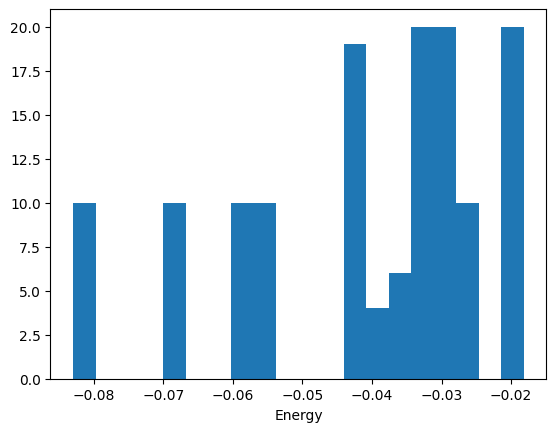

In [67]:

plt.hist(energies, 20)
plt.xlabel('Energy')

In [79]:
for atoms in atoms_list:
    atoms.calc = LennardJones(sigma = sigma, epsilon = epsilon, rcut = 10.0, )

predicted_energies = [atoms.get_potential_energy() for atoms in atoms_list]

Text(0, 0.5, 'LJ')

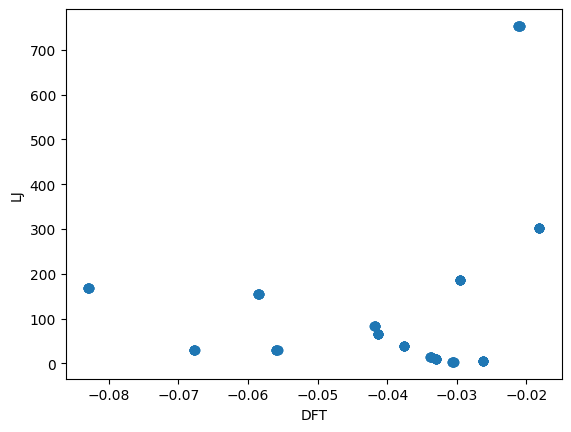

In [81]:
plt.scatter(energies, predicted_energies)
plt.xlabel('DFT')
plt.ylabel('LJ')

As you see the energies are far away from the calculated with LJ potential. This is due to the epsilon and sigma parameters. Let's find the best parameters that fits the DFT data. For this we will minimize the mean squared error of energy predictions with our LJ potential compared to the DFT data.

In [68]:
import numpy as np
from scipy.optimize import fmin
from ase.calculators.lj import LennardJones


# original code source: https://kitchingroup.cheme.cmu.edu/blog/2017/11/19/Training-the-ASE-Lennard-Jones-potential-to-DFT-calculations/



def my_lj(params):

    """
    This function return potential energy predictions
    for a given set of LJ pair potential parameters.

    Note that configurations is a global variable.
    It should be created before executing this function

    Params
    ------
    params: list of two floats, e.g. [sigma, epsilon]

    Returns
    -------

    predicted energies

    """

    global configurations
    epsilon, sigma = params
    calc = LennardJones(sigma=sigma, epsilon=epsilon)
    for atoms in configurations:
        atoms.calc = calc
    predictions = np.array([atoms.get_potential_energy() for atoms in configurations])
    return predictions


def loss(target, prediction):
    """
    Mean squared error loss function

    Params
    ------

    target: np.array
        ground truth energies

    prediction: np.array
        predicted energies

    """
    return np.square(prediction - target).mean()


def callback(params):
    #DA explain what is callback
    steps.append(params)




def objective(params):
    """
    Objective function we want to minimize

    Note that targets is a global variable.
    It should be created before executing this function.
    """
    global targets
    predictions =  my_lj(params)

    return loss(targets, predictions)

configurations = [row.toatoms() for row in db.select()]
targets = np.array([row.energy for row in db.select()])
steps = []

LJ_pars = fmin(objective, x0 = [0.5, 5.0], callback = callback)
print(LJ_pars)

Optimization terminated successfully.
         Current function value: 0.000141
         Iterations: 113
         Function evaluations: 214
[0.00592838 3.73316798]


In [69]:
loss_history = []
for step in steps:
    loss_history.append(loss(targets, my_lj(step)))

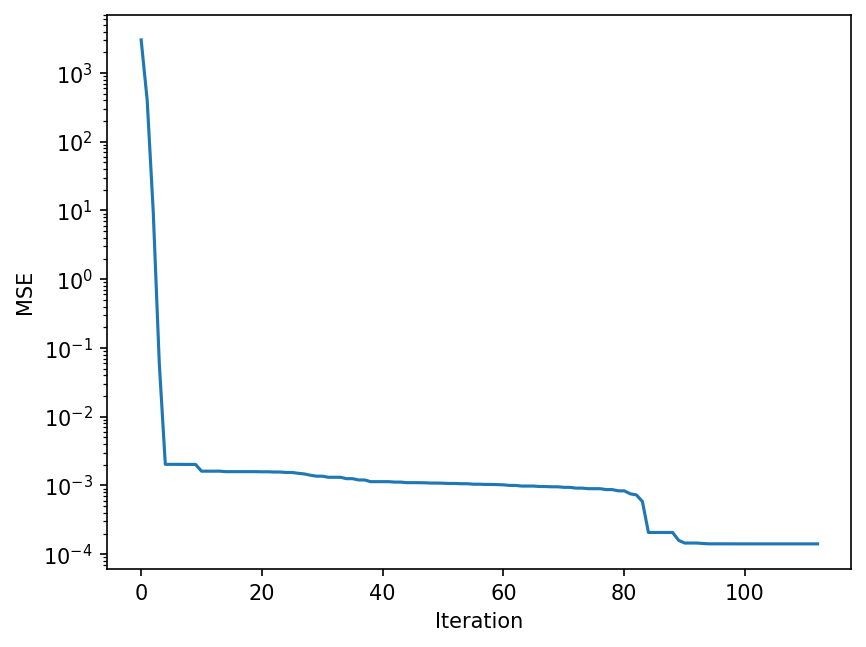

In [74]:
plt.figure(dpi = 150)
plt.plot(loss_history)
plt.ylabel('MSE')
plt.xlabel('Iteration')
plt.yscale('log')


Now we have a much better fit to the DFT data.

Text(0.5, 0, 'DFT energy')

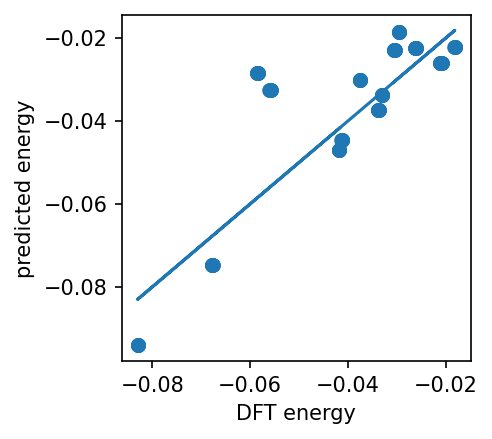

In [ ]:
fig, ax = plt.subplots(dpi = 150, figsize = (3, 3))

ax.scatter(targets, my_lj(LJ_pars))
ax.plot(targets, targets)
ax.set_ylabel('predicted energy')
ax.set_xlabel('DFT energy')

Now you have the intuition behind interatomic potential fitting. Today we will use the SevenNet universal interatomic potential trained on the MPtrj dataset - a dataset of crystal structure configurations from the Materials structure database with calculated energies, forces, and stress tensors using density functional theory. In other words, someone did the same thing we did, but instead of fitting the LJ potential with two parameters to several different structures, the graph neural network with ~700k (I need to check it) parameters (weights) was fitted to the ~1,000,000 energies, ~10,000,000 forces, and stress tensors. Universal means that this potential is intended to accurately predict energies and forces for crystal structures from a wide range of chemical systems.

This library provides the SevenNetCalculator compatible with the ASE library, which allows using the ASE functionality for running molecular dynamics simulations and optimizing crystal structures

In [ ]:
# install SevenNet library
!pip install sevenn

In [ ]:
from ase.optimize import FIRE
from ase.io import read, write
from ase.optimize import FIRE
from ase.md.npt import NPT
from ase.units import fs
from ase.build import make_supercell
import numpy as np
from sevenn.sevennet_calculator import SevenNetCalculator

In [ ]:
sevennet_0_cal = SevenNetCalculator("7net-0", device='cuda') # we use cuda device, i.e. GPU, for a faster calculations


/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

In [86]:
# Li10Ge(PS6)2, LGPS for a shorter notation, is known for its fast Li-ion conductivity
atoms = read('Li10Ge(PS6)2_mp.cif')

P = [
    [1, 0, 0],
    [0, 2, 0],
    [0, 0, 2]
]
# create supercell for better statistics
supercell = make_supercell(atoms, P)
print(len(supercell))

In [ ]:
# set calculator
supercell.calc = sevennet_0_cal
print(supercell.get_potential_energy())

-863.3062133789062


In [ ]:
# optimize crystal structure
# FIRE is the method for optimizing an objective function.
# Newtonian dynamics with added friction https://wiki.fysik.dtu.dk/ase/ase/optimize.html
optim = FIRE(supercell)

In [ ]:
optim.run(fmax = 0.01)

      Step     Time          Energy          fmax
FIRE:    0 17:01:37     -863.306213        0.079666
FIRE:    1 17:01:37     -863.311035        0.077807
FIRE:    2 17:01:37     -863.319214        0.073963
FIRE:    3 17:01:38     -863.328613        0.067917
FIRE:    4 17:01:38     -863.338501        0.059607
FIRE:    5 17:01:38     -863.349121        0.055366
FIRE:    6 17:01:38     -863.360352        0.047204


True

In [ ]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution

In [ ]:
MaxwellBoltzmannDistribution(supercell, temperature_K = 1000) # create a distribution of velocities

In [ ]:
# define the ensemble

thermo = NPT(supercell,
             temperature_K = 1000,
             timestep = 2 * fs, # convert to fs
             trajectory='md.traj',
             loginterval = 1,
             logfile='md.log',
             ttime = 40 * fs,
             pfactor = (75 * fs)**2 * 0.6,
             externalstress = 0,
             )

In [86]:
# run MD simulation for 10,000 steps
thermo.run(10000)

In [ ]:
# read saved trajectory
traj = read('md.traj', index = ':')

###Task 1: V vs. time
 Plot volume of the supercell vs. time. How long does it take to converge?

Text(0, 0.5, 'Volume, $\\AA^3$')

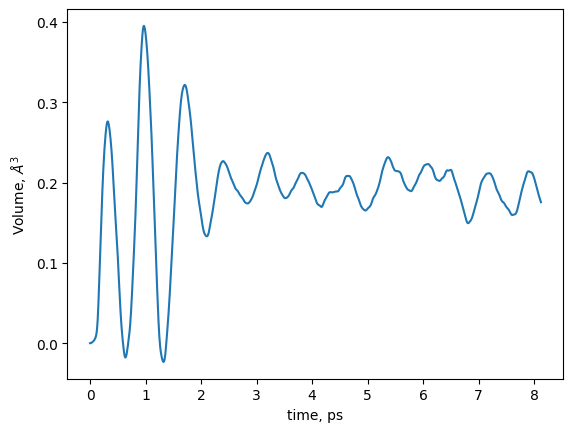

In [ ]:

plt.xlabel('time, ps')
plt.ylabel('Volume, $\AA^3$')

### Task 2. MSD

Write a function that calculates the mean squared displacement at each timestep for a given atom

![bg](https://pubs.rsc.org/image/article/2014/CP/c4cp02038c/c4cp02038c-t2_hi-res.gif)

In [86]:
def classical_msd(trajectory, specie):

    """
    Calclate classical mean squared displacement
    for a given specie

    Params:
    ------
    trajectory: list of ase's Atoms objects
        simulation trajectory

    specie: str
        atomic symbol
    """


    ### your code ###
    pass

### Task 3: MSD(element) vs. time

Plot MSD for each chemical element in the LGPS structure

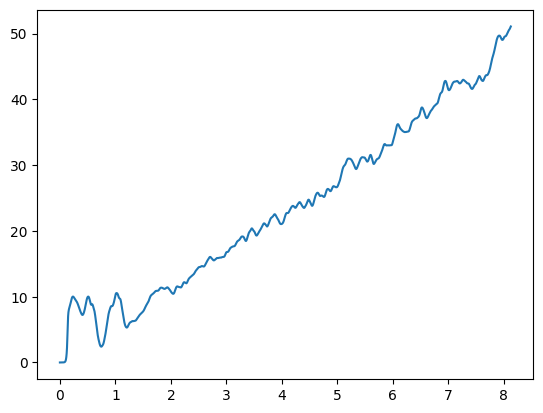

### Task 4: Slope

Fit the line to the linear region of the MSD(t) curve calculated for Li ions

In [ ]:
# your code

In [ ]:
def _diffusion_coefficient(slope, dim = 3):

    """
    slope = [A ^ 2 / ps]
    d = [cm ^ 2 / s]
    """
    d = 1 / (2 * dim) * slope * (1e-16) / (1e-12)
    return d

### Task 5. Arrhenius equation

$D = D_0\exp(-E_a/kT)$

- Run several MD simulations at different temperatures (T=600, 800, 1000)

- Fit the line to each of the MSD curves calculated for Li ion
- Calculate D(T)
- Fit the line to the log10(D) vs. 1/T
- Extract $D_0$ and $E_a$
- Compare calculated values with the literature data

literature data: https://ceder.berkeley.edu/publications/YiFei_Lithium_Conductor.pdf
